# Import required modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import celltypist
from celltypist import models

import scipy

import scanpy.external as sce

In [2]:
import session_info
session_info.show()

In [27]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Prepare functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Prepare query anndata

## Euploid

In [7]:
adata_eup = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')

# subset OCT data
adata_eup = adata_eup[adata_eup.obs['modality']=='Visium']

# subset 13PCW ventricle data
adata_eup = adata_eup[adata_eup.obs['sample']=='HCAHeartST11605165']

adata_eup.var_names_make_unique()
adata_eup

AnnData object with n_obs × n_vars = 2428 × 33562
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts',

In [8]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_eup.obs['annotation_final_mod']=adata_eup.obs['annotation_final'].astype('str').copy()
adata_eup.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_eup.obs['annotation_final_mod'] = adata_eup.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
       #  'SAnode',
       #  'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    # 'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
       #  'Endocardium - Atrial', 
    'Endocardium - Ventricular',
        'Endocardial cusion',
        'AV ring',
    'Valves',
  #   'LN',
            ]
adata_eup.obs['annotation_final_mod'].cat.reorder_categories(annotations_order, inplace=True)

In [9]:
# check spot
adata_eup.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          1213
Ventricle - Trabeculated      747
Atrium                        171
Valves                         73
Adventitia - Coronary          56
Epicardium                     55
VCS - Distal                   43
Endocardium - Ventricular      20
VCS - Proximal                 19
Endocardial cusion             17
AV ring                         7
Coronary vessel                 4
Great vessel                    2
Adventitia - GV                 1
Name: annotation_final_mod, dtype: int64

In [10]:
adata_eup.var.head(n=3)

,gene_ids
SYMBOL,
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419


## Trisomy 21

In [11]:
# t21
adata_t21 = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-T21_foetal_raw.h5ad')

# reset var_names
adata_t21.var.set_index('SYMBOL',inplace=True)
adata_t21.var_names_make_unique()

adata_t21

AnnData object with n_obs × n_vars = 11238 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    uns: 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

## Concatenate

In [12]:
# concatenate oct adata
adata_eup.obs['status'] = 'Euploid'
adata_eup.obs['status'] = 'Euploid'
adata_t21.obs['status'] = 'Trisomy21'

adata = adata_eup.concatenate(
    adata_t21,
    batch_key=None,
    index_unique=None,
    join="inner"
)

adata.obs['status'].value_counts()

Trisomy21    11238
Euploid       2428
Name: status, dtype: int64

In [13]:
# log-normalise
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Predict

In [14]:
adata.X.data[:10]

array([0.54645187, 0.54645187, 0.54645187, 0.54645187, 1.1573032 ,
       0.8978123 , 0.54645187, 0.54645187, 0.54645187, 0.54645187],
      dtype=float32)

In [15]:
prediction = celltypist.annotate(adata, 
                                  model = '/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/traindata_model_ventricle_all-spots-without-13pcw.pkl', 
                                  majority_voting = False)
adata = prediction.to_adata()

🔬 Input data has 13666 cells and 21094 genes
🔗 Matching reference genes in the model
🧬 20747 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


# Plot sections

In [16]:
adata_eup_forplot = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')

# log-normalise
sc.pp.filter_genes(adata_eup_forplot, min_cells=3)
sc.pp.normalize_total(adata_eup_forplot, target_sum=1e4)
sc.pp.log1p(adata_eup_forplot)

sc.pp.filter_genes(adata_t21, min_cells=3)
sc.pp.normalize_total(adata_t21, target_sum=1e4)
sc.pp.log1p(adata_t21)

In [17]:
adata_eup_forplot.var.set_index('SYMBOL',inplace=True)
adata_eup_forplot.var_names_make_unique()

In [18]:
# add probability matrix
prob_mat = prediction.probability_matrix.copy()
adata.obs[prob_mat.columns] = prob_mat.reindex(adata.obs_names)

# add obs
adata_t21.obs[adata.obs.columns] = adata.obs.reindex(adata_t21.obs_names)
adata_eup_forplot.obs[adata.obs.columns] = adata.obs.reindex(adata_eup_forplot.obs_names)

... storing 'status' as categorical


HCAHeartST13162336


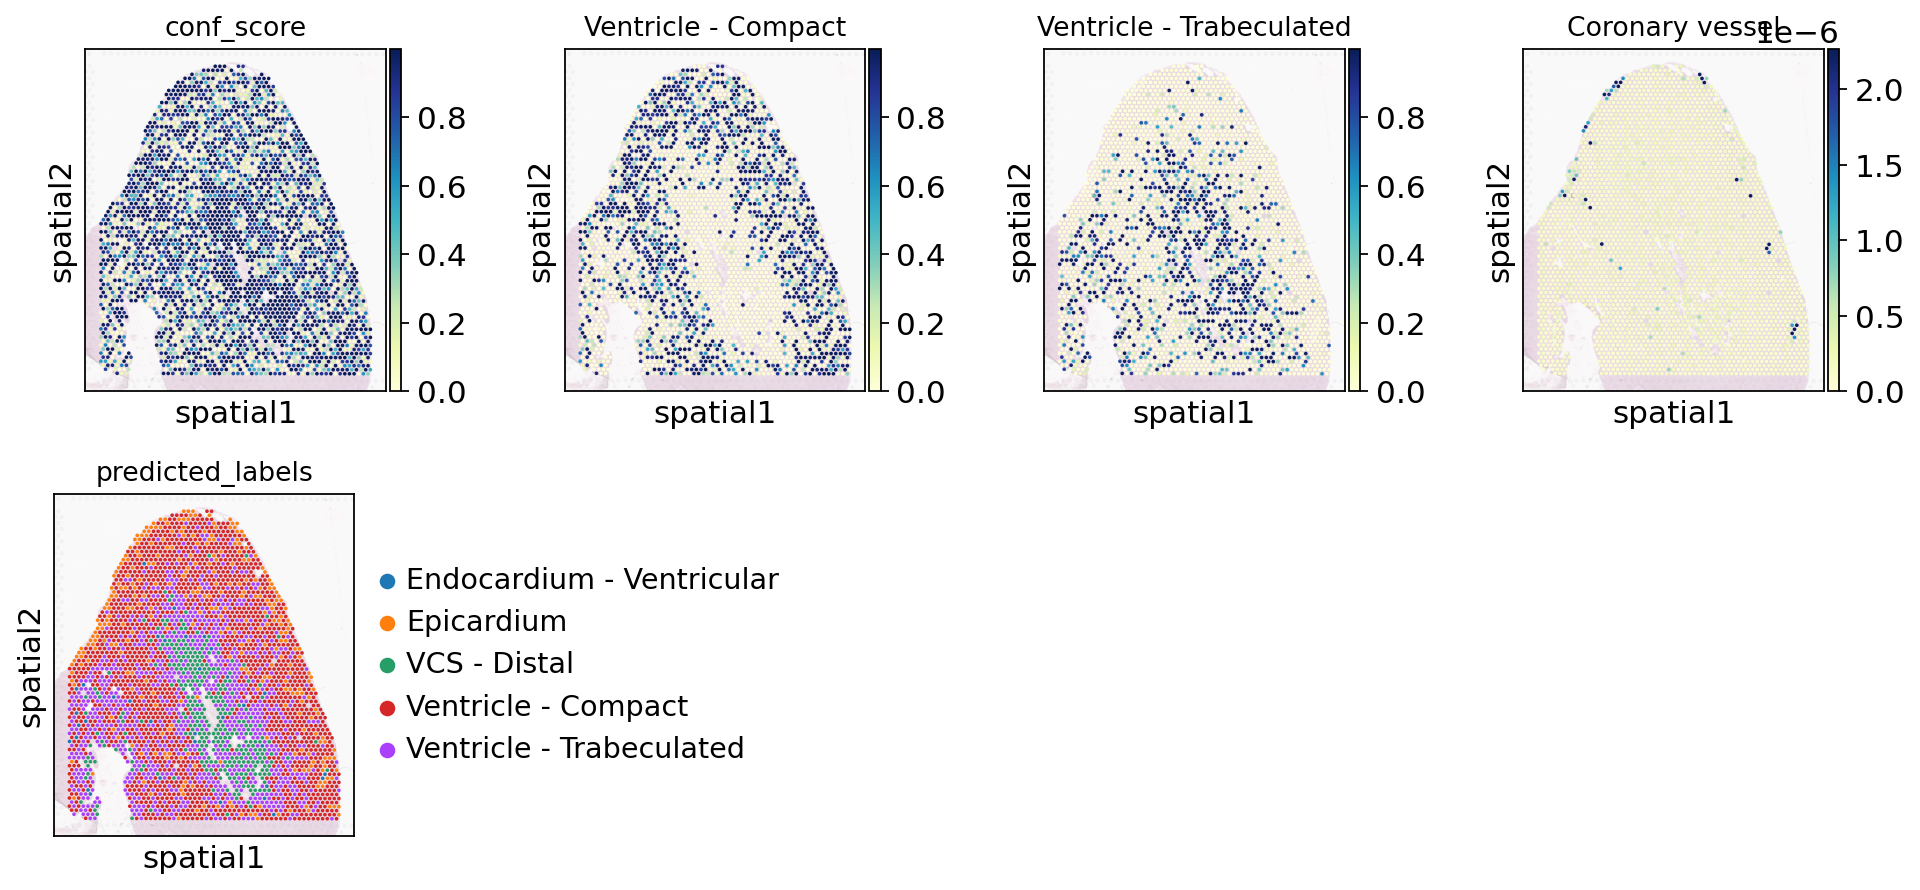

In [19]:
slide_id = 'HCAHeartST13162336'

slide = select_multislide(adata_t21, [slide_id], s_col='sample')

with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':12,}):
    # cells
    print(slide_id)
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=['conf_score','Ventricle - Compact','Ventricle - Trabeculated','Coronary vessel','predicted_labels',], 
                  ncols=4, wspace=0.2,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.4',
                  # title=slide_id
                  # palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

... storing 'status' as categorical


HCAHeartST11605165


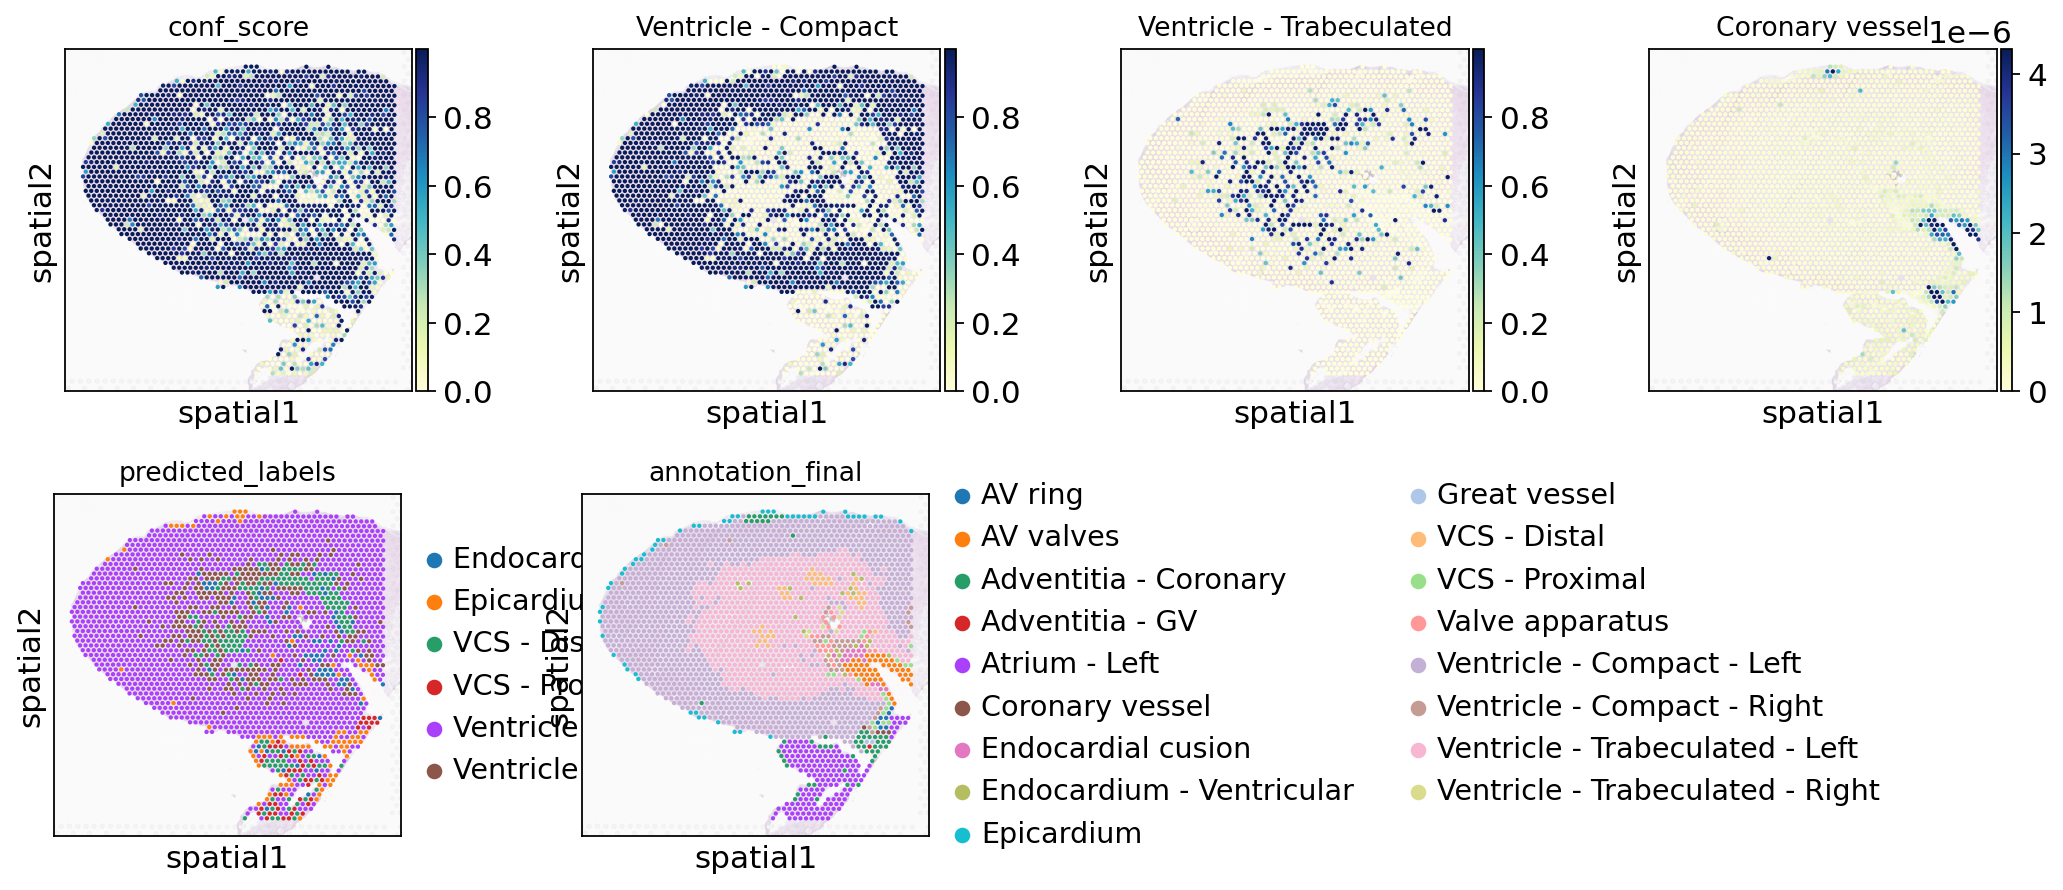

In [20]:
slide_id = 'HCAHeartST11605165'
slide = select_multislide(adata_eup_forplot, [slide_id], s_col='sample')

with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':12,}):
    # cells
    print(slide_id)
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=['conf_score','Ventricle - Compact','Ventricle - Trabeculated','Coronary vessel','predicted_labels','annotation_final'], 
                  ncols=4, wspace=0.3,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.4',
                  # title=slide_id
                  # palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

... storing 'status' as categorical


HCAHeartST13162336


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 30 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 25, 27, 38, 55, 57, 68, 69, 70, 71, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closed glyph list over 'GSUB': 30 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 25, 27, 38, 55, 57, 68, 69, 70, 71, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closing glyph list over 'MATH': 30 glyphs before
Glyp

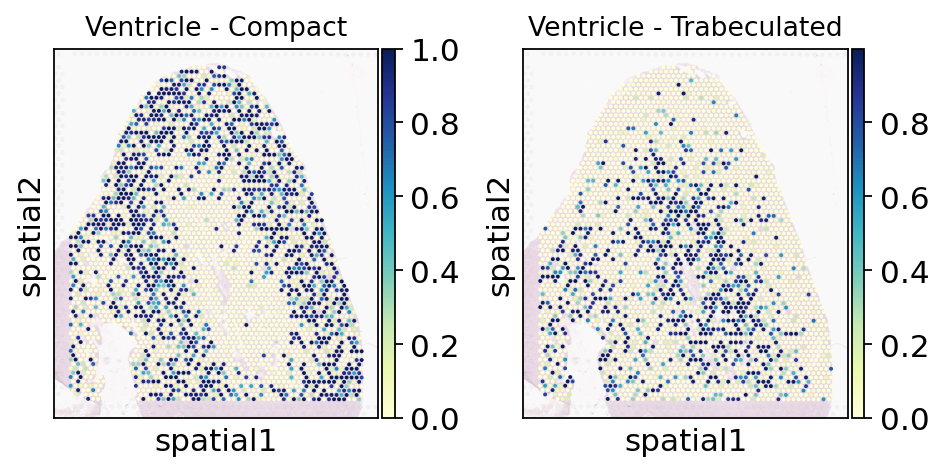

In [34]:
# plot for figure
slide_id = 'HCAHeartST13162336'

slide = select_multislide(adata_t21, [slide_id], s_col='sample')

with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':12,}):
    # cells
    print(slide_id)
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=['Ventricle - Compact','Ventricle - Trabeculated'], 
                  ncols=4, wspace=0.15,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p100',
                  show=False
                 )
    plt.savefig(f"{figdir}/tissuetypist_T21-predict_{slide_id}.pdf", bbox_inches="tight",dpi=300)

... storing 'status' as categorical


HCAHeartST11605165


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 30 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 25, 27, 38, 55, 57, 68, 69, 70, 71, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closed glyph list over 'GSUB': 30 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 25, 27, 38, 55, 57, 68, 69, 70, 71, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
Closing glyph list over 'MATH': 30 glyphs before
Glyp

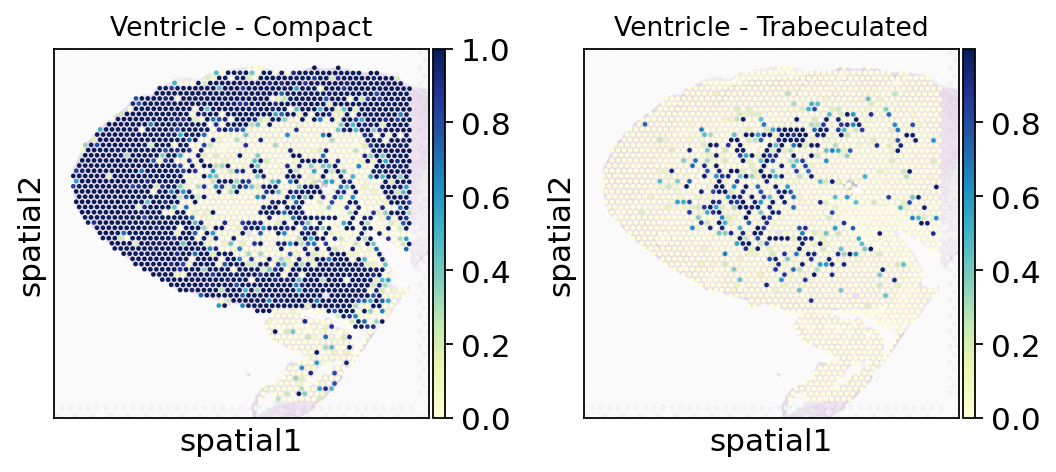

In [38]:
slide_id = 'HCAHeartST11605165'
slide = select_multislide(adata_eup_forplot, [slide_id], s_col='sample')

with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':12,}):
    # cells
    print(slide_id)
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=['Ventricle - Compact','Ventricle - Trabeculated'], 
                  ncols=4, wspace=0.25,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p100',
                  show=False
                 )
    plt.savefig(f"{figdir}/tissuetypist_Euploid-predict_{slide_id}.pdf", bbox_inches="tight",dpi=300)

# Add axis

In [21]:
!ls /nfs/team205/heart/visium_axis/foetal/transmural_LV

BHF_F_Hea13295830.csv	HCAHeartST10317186.csv	HCAHeartST13162330.csv
BHF_F_Hea13295831.csv	HCAHeartST11605165.csv	HCAHeartST13162331.csv
HCAHeartST10317184.csv	HCAHeartST11605167.csv	HCAHeartST13162336.csv
HCAHeartST10317185.csv	HCAHeartST11605168.csv


In [22]:
# add
oct_samples = list(set(adata.obs['sample']))

adata.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
adata_tm = adata[adata.obs['transmural_axis'].isna()==False]
adata_tm

View of AnnData object with n_obs × n_vars = 3777 × 21094
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibro

In [28]:
?tissueaxis.plot_axis_split

Signature:
tissueaxis.plot_axis_split(
    adata,
    feature_to_plot,
    splitby,
    groups_order=None,
    axis_col='transmural_axis',
    n_bin=15,
    feature_type='gene',
    min_max_scale=True,
    row_cluster=False,
    figsize=(3, 8),
    cbar_pos=(0, 0.5, 0.05, 0.18),
    cmap='viridis',
    xticklabels=True,
    yticklabels=True,
    title=None,
    save=None,
    save_dpi=300,
    **kwargs,
)
Docstring: <no docstring>
File:      /nfs/team205/kk18/function/python/tissueaxis.py
Type:      function

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 32 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'P', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'x', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 38, 51, 55, 57, 58, 66, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 91]
Closed glyph list over 'GSUB': 32 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'P', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'x', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 38, 51, 55, 57, 58, 66, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 91]
Closing glyph list 

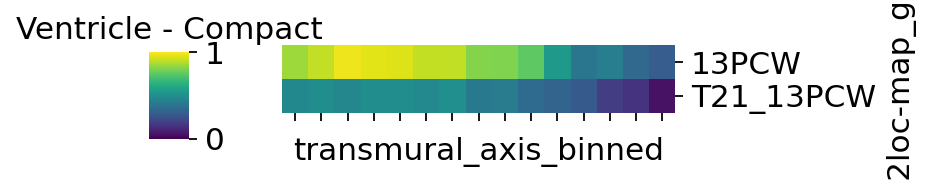

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 32 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'P', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'x', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 38, 51, 55, 57, 58, 66, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 91]
Closed glyph list over 'GSUB': 32 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'P', 'T', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'x', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 38, 51, 55, 57, 58, 66, 68, 69, 70, 71, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 91]
Closing glyph list 

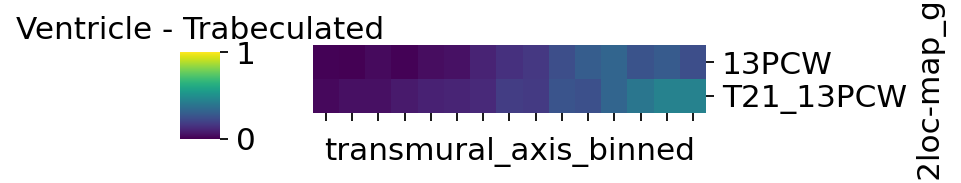

In [29]:
# plot along transmural axis
for feature in ['Ventricle - Compact',
                 'Ventricle - Trabeculated',
                ]:
    
    tissueaxis.plot_axis_split(adata_tm,
                           feature_to_plot=feature,
                           feature_type='obs',
                               min_max_scale=False,
                           splitby='cell2loc-map_group',
                           groups_order=[ '13PCW','T21_13PCW'],
                           figsize=(5, 3),
                           cbar_pos=(0, 0.7, 0.05, 0.18),
                               vmax=1,vmin=0,
                           save=f'{figdir}/tissuetypist_tm-axis_{feature}.pdf',   
                          )